# 1. CNN (Two dimensional)

## 1.1 Loading data

In [1]:
import csv
from math import sqrt
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
import numpy as np

class UltrasonicData:
    """ A custom data type: the data member is 
    - the distances from the car to the surrounding wall at one or multiple sample time
    - and corresponding control commands for the angular velocity.
    """
    def __init__(self, distance, angular):
        self.distance = distance
        self.angular  = angular
        
        
def csv_read(csv_path, length):
    """ Reading raw ultrasonic data from csv file
    
    input: 
     - csv_path: the path of the csv file
     - length: the length of time sequence used in each training data
    output: 
     - Return the shuffled data which is represented in UltrasonicData type.
    """
    
    print("Starting reading data from csv file...")
    # save time-ordered data sequences
    D = []
    agl = []
    # save time-independent data by slicing D with the desired length 
    Data = []
    
    with open(csv_path, 'r') as f:
        f_reader = csv.reader(f)
        for line in f_reader:
            D.append([sqrt(float(line[i])**2 + float(line[i+16])**2) for i in range(16)])
            agl.append(float(line[33]))
    
    # now the data is sorted by time
    print("{} original data has been read in time order.".format(len(D)))
    
    for i in range(len(D)-length+1):
        distance = D[i:i+length]
        # use the value at the final time sequence as a label
        angular = agl[i+length-1] 
        
        Data.append(UltrasonicData(distance, angular))
    
    print("Now we have {} data after slicing with length {}".format(len(Data), length))
    
    return shuffle(Data)


def loading_data_set(csv_path, length, split=0.2):
    """ Loading and spliting dataset
    
    """
    Data = csv_read(csv_path, length)
    training_set, validation_set = train_test_split(Data, test_size=split)
    
    print("The training set size is {}".format(len(training_set)))
    print("The validation set size is {}".format(len(validation_set)))

    
    return training_set, validation_set


def data_generator(Data, batch_size):
    """ A data generator which generating a batch of data every time
    1. The data is reshaped to (batch_size, length*16)
    
    """
    while True:
        data_batch = np.random.choice(a=Data, size=batch_size)
        X = []
        Y = []
    
        for i in range(len(data_batch)):
            data = data_batch[i]
            # repeat coloums and rows 4 times
            array = np.array(data.distance)
            data_repeat = array.repeat(4, axis=0)
            data_repeat = data_repeat.repeat(4, axis=1)

            X.append(data_repeat)
            Y.append(data.angular)
            
        # batch_size, H, W = X.shape
        X = np.array(X)
        
        # add new axis for the gray scale image
        X = X[:, np.newaxis, :,:]
        Y = np.array(Y)
    
        yield shuffle(X,Y)

In [3]:
"""
TESTING DATA LOADING FUNCTION
"""

data_path  = "/media/ubuntu16/Documents/datasets/SonarSet/SIM/Track-I/"
filename = "2019-06-06.csv"
csv_path = data_path + filename
batch_size = 128
lengths = [16,32,48]

for length in lengths:
    training_set, validation_set = loading_data_set(csv_path, length, split=0.2)
    # load data through generator
    
    train_generator = data_generator(training_set, batch_size)
    valid_generator = data_generator(validation_set, batch_size)
    
    x1,y1 = next(train_generator)
    x2,y2 = next(valid_generator)
    print x1.shape, y1.shape
    print x2.shape, y2.shape
    print

Starting reading data from csv file...
6509 original data has been read in time order.
Now we have 6494 data after slicing with length 16
The training set size is 5195
The validation set size is 1299
(128, 1, 64, 64) (128,)
(128, 1, 64, 64) (128,)

Starting reading data from csv file...
6509 original data has been read in time order.
Now we have 6478 data after slicing with length 32
The training set size is 5182
The validation set size is 1296
(128, 1, 128, 64) (128,)
(128, 1, 128, 64) (128,)

Starting reading data from csv file...
6509 original data has been read in time order.
Now we have 6462 data after slicing with length 48
The training set size is 5169
The validation set size is 1293
(128, 1, 192, 64) (128,)
(128, 1, 192, 64) (128,)



## 1.2 Training


In [3]:
from math import ceil
from keras.models import Sequential
from keras.layers import Lambda, Conv2D, Flatten, Dense
from keras.callbacks import ModelCheckpoint
from keras.models import load_model


data_path  = "/media/ubuntu16/Documents/datasets/SonarSet/SIM/Track-I/"
filename = "2019-06-06.csv"
csv_path = data_path + filename

batch_size = 128
epochs = 500

lengths = [16, 32, 48]

historys = {}
errors = {}

model_path = "/home/ubuntu16/catkin_ws/src/sonar_navigation/h5/"


for length in lengths:
    # reading data from csv
    training_set, validation_set = loading_data_set(csv_path, length, split=0.2)
    # loading data through generator
    train_generator = data_generator(training_set, batch_size)
    valid_generator = data_generator(validation_set, batch_size)
    
    training_steps = ceil(len(training_set)/batch_size)
    validation_steps = ceil(len(validation_set)/batch_size)
    
    prefix = 'cnn'+'-'+str(length)
    
    model = Sequential()
    
    # Normalization [-0.5, 0.5]
    model.add(Lambda(lambda x: (x-2.5)/5.0, input_shape=(1, length*4, 64)))
    
    # Conv1
    model.add(Conv2D(24, kernel_size=(5,5), strides=(2,2), padding='valid', 
                     data_format='channels_first', activation='relu'))

    # Conv2
    model.add(Conv2D(36, kernel_size=(5,5), strides=(2,2), padding='valid', 
                     data_format='channels_first', activation='relu'))

    # Conv3
    model.add(Conv2D(48, kernel_size=(5,5), strides=(2,2), padding='valid', 
                     data_format='channels_first', activation='relu'))

    # conv4
    model.add(Conv2D(64, kernel_size=(3,3), strides=(1,1), padding='valid', 
                     data_format='channels_first', activation='relu'))

    # Conv5
    model.add(Conv2D(64, kernel_size=(3,3), strides=(1,1), padding='valid', 
                     data_format='channels_first', activation='relu'))

    # Flatten
    model.add(Flatten())

    # FC1
    model.add(Dense(100, activation='relu'))

    # FC2
    model.add(Dense(50, activation='relu'))

    # FC3
    model.add(Dense(10, activation='relu'))

    # output
    model.add(Dense(1))

    # compile        
    model.compile(loss='mean_absolute_error', optimizer='adam', metrics=['mean_absolute_error'])
    model.summary()
    model_checkpoint = ModelCheckpoint(model_path+prefix+'-'+'best_model.h5', 
                                       monitor='val_mean_absolute_error',
                                       save_best_only=True)
    model_callbacks = [model_checkpoint]

    # fit model
    history = model.fit_generator(generator = train_generator,
                                  steps_per_epoch  = training_steps,
                                  validation_data  = valid_generator,
                                  validation_steps = validation_steps,
                                  epochs  = epochs,
                                  verbose = 0,
                                  callbacks = model_callbacks)
    # save training histroys
    hist_key = prefix + '-'+'mae'
            
    historys[hist_key] = history
        
    # load the saved model
    saved_model = load_model(model_path+prefix+'-'+'best_model.h5')
        
    # evalute model
    train_loss, train_mae = saved_model.evaluate_generator(train_generator, 
                                                               steps=training_steps,
                                                               verbose=0)
    val_loss, val_mae= saved_model.evaluate_generator(valid_generator, 
                                                          steps=validation_steps,
                                                          verbose=0)
    errors[prefix+'-'+'train'] = train_mae
    errors[prefix+'-'+'val'] = val_mae


    print('{}: Train: {}, validation: {}'.format(hist_key, train_mae, val_mae))
    print(" ")



Starting reading data from csv file...
6509 original data has been read in time order.
Now we have 6494 data after slicing with length 16
The training set size is 5195
The validation set size is 1299
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lambda_1 (Lambda)            (None, 1, 64, 64)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 24, 30, 30)        624       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 36, 13, 13)        21636     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 48, 5, 5)          43248     
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 64, 3, 3)          27712     
_________________________________________________________________
conv2d_5

KeyboardInterrupt: 

## 1.4 Training History

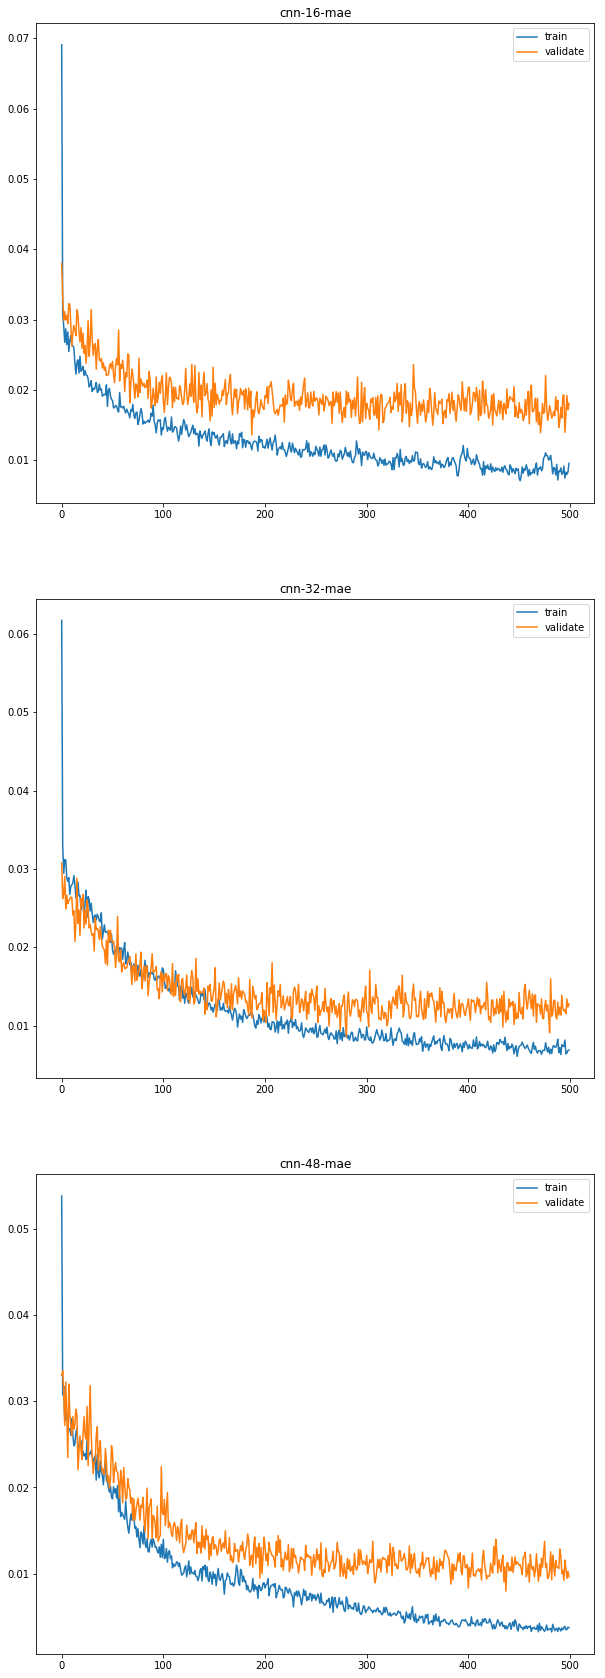

In [11]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(3,1, figsize=(10, 30))

index = 0
for key in sorted(historys.keys()):
    axes[index].plot(historys[key].history['loss'], label='train')
    axes[index].plot(historys[key].history['val_loss'], label='validate')
    axes[index].set_title(key)
    axes[index].legend()
    index +=1
    
plt.show()

In [109]:
x1,y1 = next(train_generator)

old_time = datetime.datetime.now()


test_array = x1

# desired input shape is (1,16)
prediction= model_mlp.predict(test_array, batch_size=1)
diff_time = datetime.datetime.now() - old_time
print("Prdiction is done! Totally use {} seconds, {} microseconds".format(diff_time.seconds, 
                                                                          diff_time.microseconds))
print("prediction is : {}, the truth is {}".format(prediction[0][0], y1))

Prdiction is done! Totally use 0 seconds, 816 microseconds
prediction is : 0.00739585608244, the truth is [0.25585192]


In [14]:
prediction[0][0]

0.0942827

In [12]:
historys

{'cnn-16-mae': <keras.callbacks.History at 0x7f2c3184cdd0>,
 'cnn-32-mae': <keras.callbacks.History at 0x7f2bd7113490>,
 'cnn-48-mae': <keras.callbacks.History at 0x7f2bcb383250>}

# Try

In [3]:
from math import ceil
from keras.models import Sequential
from keras.layers import Lambda, Conv2D, Flatten, Dense
from keras.callbacks import ModelCheckpoint
from keras.models import load_model


data_path  = "/media/ubuntu16/Documents/datasets/SonarSet/SIM/Track-I/"
filename = "2019-06-06.csv"
csv_path = data_path + filename

batch_size = 128
epochs = 500
lengths = [16, 32, 48]

historys = {}
errors = {}

model_path = "/home/ubuntu16/catkin_ws/src/sonar_navigation/h5/"


for length in lengths:
    # reading data from csv
    training_set, validation_set = loading_data_set(csv_path, length, split=0.2)
    # loading data through generator
    train_generator = data_generator(training_set, batch_size)
    valid_generator = data_generator(validation_set, batch_size)
    
    training_steps = ceil(len(training_set)/batch_size)
    validation_steps = ceil(len(validation_set)/batch_size)
    
    prefix = 'mcnn-'+str(length)
    
    model = Sequential()
    
    # Normalization [-0.5, 0.5]
    model.add(Lambda(lambda x: (x-2.5)/5.0, input_shape=(1, length*4, 64)))
    
    # Conv1
    model.add(Conv2D(24, kernel_size=(3,3), strides=(2,2), padding='valid', 
                     data_format='channels_first', activation='relu'))
    
    model.add(Conv2D(36, kernel_size=(3,3), strides=(2,2), padding='valid', 
                     data_format='channels_first', activation='relu'))
    
    model.add(Conv2D(48, kernel_size=(3,3), strides=(2,2), padding='valid', 
                     data_format='channels_first', activation='relu'))

    # conv4
    model.add(Conv2D(64, kernel_size=(3,3), strides=(1,1), padding='valid', 
                     data_format='channels_first', activation='relu'))

    # Conv5
    model.add(Conv2D(64, kernel_size=(3,3), strides=(1,1), padding='valid', 
                     data_format='channels_first', activation='relu'))

    # Flatten
    model.add(Flatten())

    # FC1
    model.add(Dense(100, activation='relu'))

    # FC2
    model.add(Dense(50, activation='relu'))

    # FC3
    model.add(Dense(10, activation='relu'))

    # output
    model.add(Dense(1))

    # compile        
    model.compile(loss='mean_absolute_error', optimizer='adam', metrics=['mean_absolute_error'])
    model.summary()
    model_checkpoint = ModelCheckpoint(model_path+prefix+'-'+'best_model.h5', 
                                       monitor='val_mean_absolute_error',
                                       save_best_only=True)
    model_callbacks = [model_checkpoint]

    # fit model
    history = model.fit_generator(generator = train_generator,
                                  steps_per_epoch  = training_steps,
                                  validation_data  = valid_generator,
                                  validation_steps = validation_steps,
                                  epochs  = epochs,
                                  verbose = 0,
                                  callbacks = model_callbacks)
    # save training histroys
    hist_key = prefix + '-'+'mae'
            
    historys[hist_key] = history
        
    # load the saved model
    saved_model = load_model(model_path+prefix+'-'+'best_model.h5')
        
    # evalute model
    train_loss, train_mae = saved_model.evaluate_generator(train_generator, 
                                                               steps=training_steps,
                                                               verbose=0)
    val_loss, val_mae= saved_model.evaluate_generator(valid_generator, 
                                                          steps=validation_steps,
                                                          verbose=0)
    errors[prefix+'-'+'train'] = train_mae
    errors[prefix+'-'+'val'] = val_mae


    print('{}: Train: {}, validation: {}'.format(hist_key, train_mae, val_mae))
    print(" ")



Starting reading data from csv file...
6509 original data has been read in time order.
Now we have 6494 data after slicing with length 16
The training set size is 5195
The validation set size is 1299
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lambda_1 (Lambda)            (None, 1, 64, 64)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 24, 31, 31)        240       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 36, 15, 15)        7812      
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 48, 7, 7)          15600     
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 64, 5, 5)          27712     
_________________________________________________________________
conv2d_5

In [4]:
errors

{'mcnn-16-train': 0.013888884615153075,
 'mcnn-16-val': 0.012282487703487277,
 'mcnn-32-train': 0.007835213950602337,
 'mcnn-32-val': 0.016118508856743576,
 'mcnn-48-train': 0.007497835910180583,
 'mcnn-48-val': 0.012401922186836601}

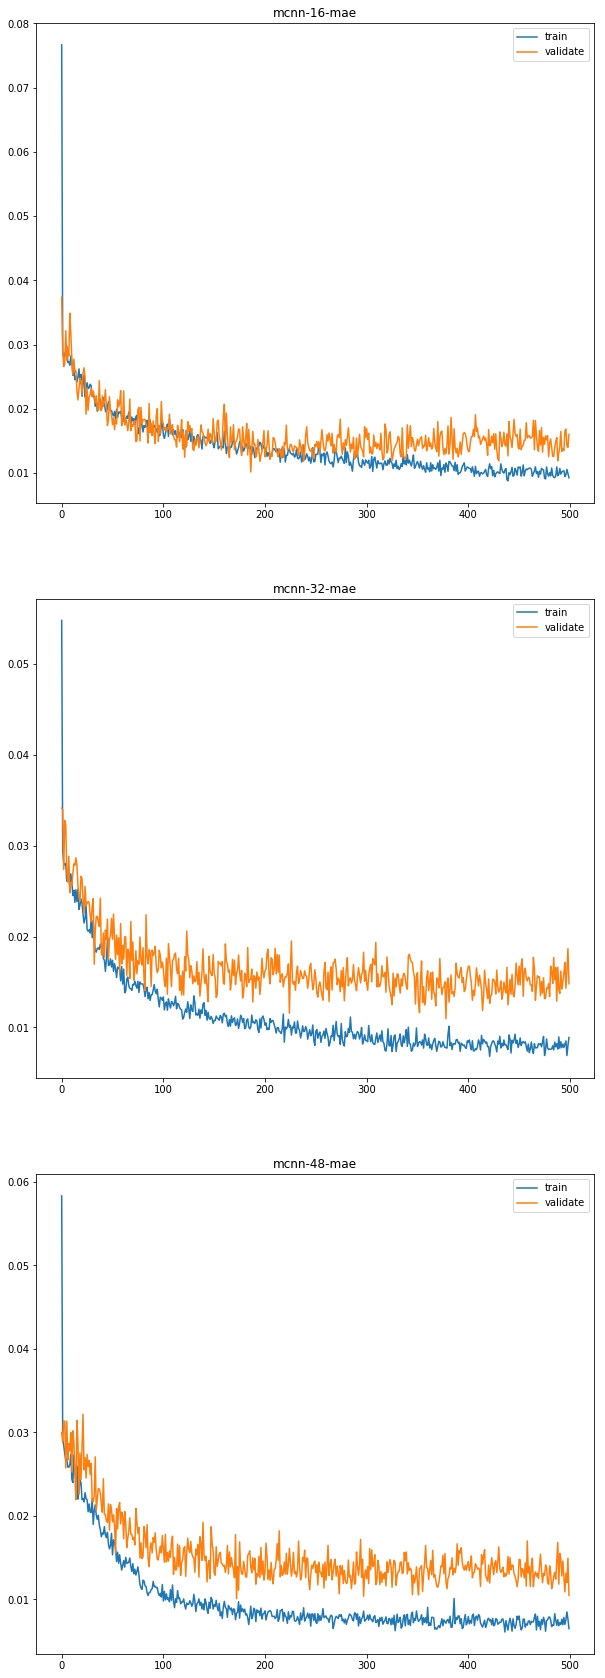

In [6]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(3,1, figsize=(10, 30))

index = 0
for key in sorted(historys.keys()):
    axes[index].plot(historys[key].history['loss'], label='train')
    axes[index].plot(historys[key].history['val_loss'], label='validate')
    axes[index].set_title(key)
    axes[index].legend()
    index +=1
    
plt.show()

In [7]:
from math import ceil
from keras.models import Sequential
from keras.layers import Lambda, Conv2D, Flatten, Dense
from keras.callbacks import ModelCheckpoint
from keras.models import load_model


data_path  = "/media/ubuntu16/Documents/datasets/SonarSet/SIM/Track-I/"
filename = "2019-06-06.csv"
csv_path = data_path + filename

batch_size = 128
epochs = 500
lengths = [16, 32, 48]

historys = {}
errors = {}

model_path = "/home/ubuntu16/catkin_ws/src/sonar_navigation/h5/"


for length in lengths:
    # reading data from csv
    training_set, validation_set = loading_data_set(csv_path, length, split=0.2)
    # loading data through generator
    train_generator = data_generator(training_set, batch_size)
    valid_generator = data_generator(validation_set, batch_size)
    
    training_steps = ceil(len(training_set)/batch_size)
    validation_steps = ceil(len(validation_set)/batch_size)
    
    prefix = 'm1cnn-'+str(length)
    
    model = Sequential()
    
    # Normalization [-0.5, 0.5]
    model.add(Lambda(lambda x: (x-2.5)/5.0, input_shape=(1, length*4, 64)))
    
    # Conv1
    model.add(Conv2D(24, kernel_size=(3,3), strides=(2,2), padding='valid', 
                     data_format='channels_first', activation='relu'))
    
    model.add(Conv2D(36, kernel_size=(3,3), strides=(2,2), padding='valid', 
                     data_format='channels_first', activation='relu'))
    
    model.add(Conv2D(48, kernel_size=(3,3), strides=(1,1), padding='valid', 
                     data_format='channels_first', activation='relu'))

    # conv4
    model.add(Conv2D(64, kernel_size=(3,3), strides=(1,1), padding='valid', 
                     data_format='channels_first', activation='relu'))


    # Flatten
    model.add(Flatten())

    # FC1
    model.add(Dense(100, activation='relu'))

    # FC3
    model.add(Dense(10, activation='relu'))

    # output
    model.add(Dense(1))

    # compile        
    model.compile(loss='mean_absolute_error', optimizer='adam', metrics=['mean_absolute_error'])
    model.summary()
    model_checkpoint = ModelCheckpoint(model_path+prefix+'-'+'best_model.h5', 
                                       monitor='val_mean_absolute_error',
                                       save_best_only=True)
    model_callbacks = [model_checkpoint]

    # fit model
    history = model.fit_generator(generator = train_generator,
                                  steps_per_epoch  = training_steps,
                                  validation_data  = valid_generator,
                                  validation_steps = validation_steps,
                                  epochs  = epochs,
                                  verbose = 0,
                                  callbacks = model_callbacks)
    # save training histroys
    hist_key = prefix + '-'+'mae'
            
    historys[hist_key] = history
        
    # load the saved model
    saved_model = load_model(model_path+prefix+'-'+'best_model.h5')
        
    # evalute model
    train_loss, train_mae = saved_model.evaluate_generator(train_generator, 
                                                               steps=training_steps,
                                                               verbose=0)
    val_loss, val_mae= saved_model.evaluate_generator(valid_generator, 
                                                          steps=validation_steps,
                                                          verbose=0)
    errors[prefix+'-'+'train'] = train_mae
    errors[prefix+'-'+'val'] = val_mae


    print('{}: Train: {}, validation: {}'.format(hist_key, train_mae, val_mae))
    print(" ")



Starting reading data from csv file...
6509 original data has been read in time order.
Now we have 6494 data after slicing with length 16
The training set size is 5195
The validation set size is 1299
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lambda_4 (Lambda)            (None, 1, 64, 64)         0         
_________________________________________________________________
conv2d_16 (Conv2D)           (None, 24, 31, 31)        240       
_________________________________________________________________
conv2d_17 (Conv2D)           (None, 36, 15, 15)        7812      
_________________________________________________________________
conv2d_18 (Conv2D)           (None, 48, 13, 13)        15600     
_________________________________________________________________
conv2d_19 (Conv2D)           (None, 64, 11, 11)        27712     
_________________________________________________________________
flatten_

In [8]:
errors


{'m1cnn-16-train': 0.012801294273231179,
 'm1cnn-16-val': 0.013154120370745658,
 'm1cnn-32-train': 0.008093868725700304,
 'm1cnn-32-val': 0.018047218304127456,
 'm1cnn-48-train': 0.00886583692044951,
 'm1cnn-48-val': 0.011797982221469282}

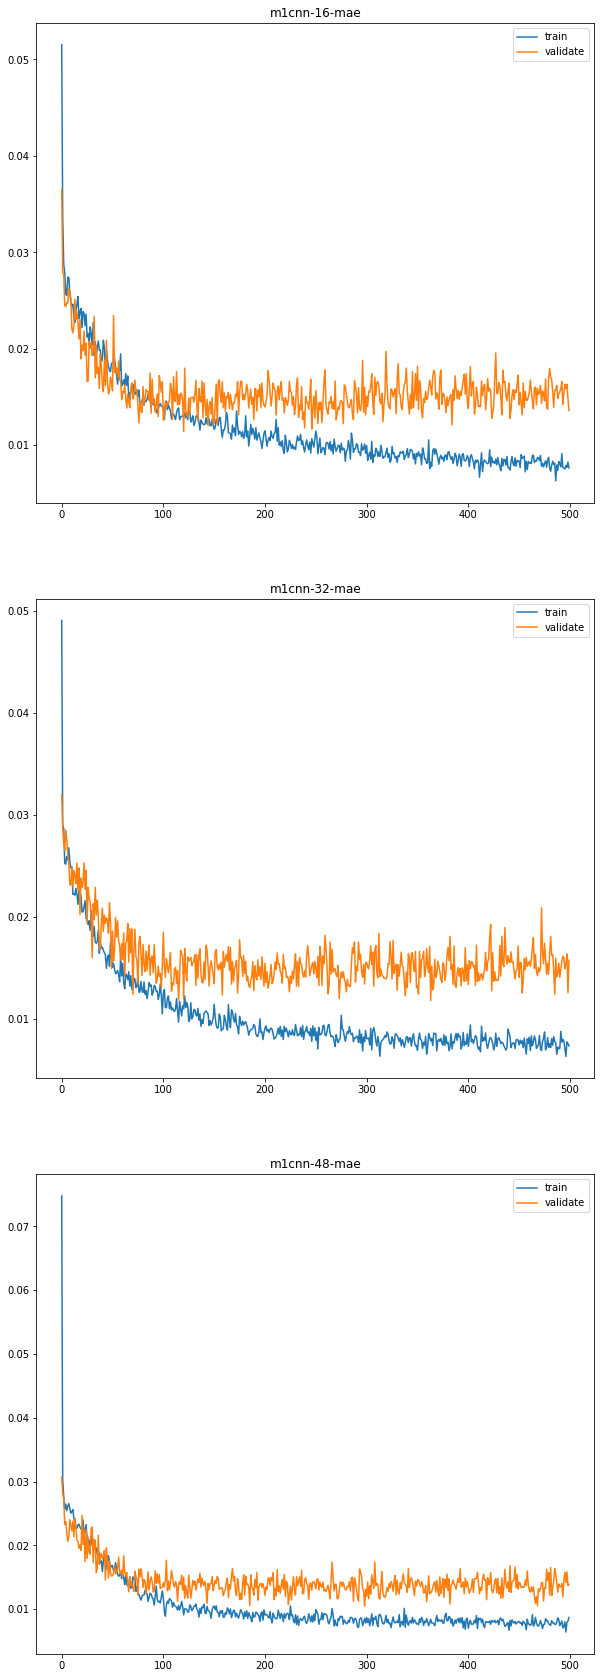

In [9]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(3,1, figsize=(10, 30))

index = 0
for key in sorted(historys.keys()):
    axes[index].plot(historys[key].history['loss'], label='train')
    axes[index].plot(historys[key].history['val_loss'], label='validate')
    axes[index].set_title(key)
    axes[index].legend()
    index +=1
    
plt.show()